## Example 4.
### Sensitivity of hydraulic head at a point to a <font color='blue'>source/sink term</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}-Q_w(x_w)=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad h(x)=h_{\Gamma_{1_0}}\ ,\quad\quad\quad\quad\quad x=0=\Gamma_{1_0}\cr
\end{align}$

$\begin{align}
\quad\quad h(x)=h_{\Gamma_{1_L}}\ ,\quad\quad\quad\quad\quad x=L=\Gamma_{1_L}\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad \rm{Not\ available}
\cr\cr\end{align}$

Spatial derivatives from differentiation:

$\begin{align}
\quad\quad \rm{Not\ available}
\cr\end{align}$

In [126]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [127]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

xw, Qw, K, b, L, BC1h0, BC1hL, ocol = 2500., 0.5, 10., 10., 10000., 50., 0., 5000
X = np.arange(L)

## 1. Direct sensitivity
$\begin{align}
\quad\quad \rm{Not\ available}
\cr\end{align}$

## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial Q_w}\approx\frac{h(x,Q_w+\Delta Q_w)-h(x,Q_w)}{\Delta Q_w}\;
\cr\cr\end{align}$

### 2a. Analytical
$\begin{align}
\quad\quad \rm{Not\ available}
\cr\end{align}$

### 2b. Semi-analytical

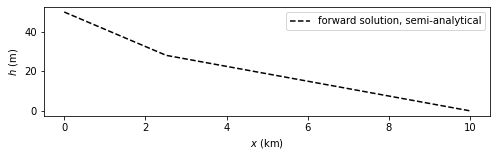

In [128]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

dpar = 1e-4
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.HeadLineSink1D(M0, xls=0., hls=BC1h0)
timml.HeadLineSink1D(M0, xls=L,  hls=BC1hL)
timml.LineSink1D(M0, xls=xw, sigls=Qw)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

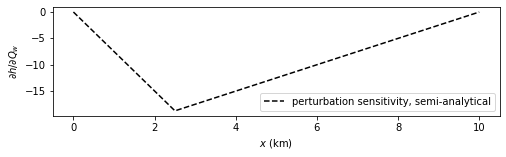

In [129]:
M1 = timml.Model3D(kaq=K, z=[0., -b])
timml.HeadLineSink1D(M1, xls=0., hls=BC1h0)
timml.HeadLineSink1D(M1, xls=L,  hls=BC1hL)
timml.LineSink1D(M1, xls=xw, sigls=Qw+Qw*dpar)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdQw = (H1-H0)/(Qw*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdQw, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial Q_w$')
plt.legend();

In [130]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdQw[ocol])

-12.500000


### 2c. Numerical

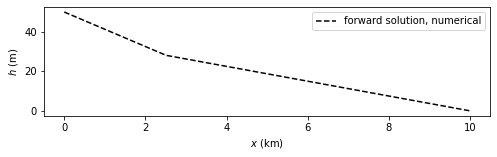

In [132]:
import flopy

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([-1*np.ones([1,1]), np.ones([nrow, ncol-2], dtype=int), -1*np.ones([1,1])]), 
                         strt=np.hstack([BC1h0*np.ones([1,1]), BC1hL*np.ones([nrow, ncol-2]), BC1hL*np.ones([1,1])]))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, xw, -0.5]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

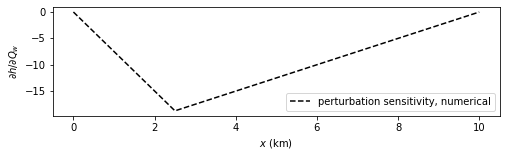

In [133]:
M1 = M0
flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, xw, -1.*(Qw+Qw*dpar)]})
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdK = (H1-H0)/(Qw*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdQw, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial Q_w$')
plt.legend();

In [134]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdQw[ocol])

-12.500000


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial Q_w}=\int\limits_X\psi^*_1(x)\ \delta(x-x_w)\; dx\ =\ \psi^*_1(x_w)
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\quad\quad\quad\quad\quad x=0=\Gamma_{1_0}\cr
\end{align}$

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\quad\quad\quad\quad\quad x=L=\Gamma_{1_L}\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad \rm{Not\ available}
\cr\end{align}$

### 3a. Analytical

$\begin{align}
\quad\quad \rm{Not\ available}
\cr\end{align}$

### 3b. Semi-analytical

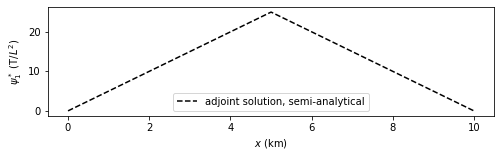

In [135]:
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.HeadLineSink1D(M0, xls=0., hls=0.)
timml.HeadLineSink1D(M0, xls=L,  hls=0.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend();

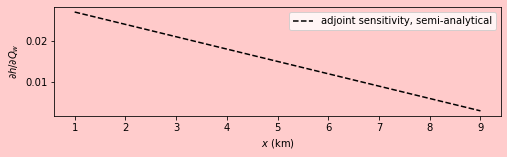

In [137]:
dhdQw = np.empty(0)
for xp in X[::1000]:
    M0 = timml.Model3D(kaq=K, z=[0., -b])
    timml.HeadLineSink1D(M0, xls=0., hls=0.)
    timml.HeadLineSink1D(M0, xls=L,  hls=0.)
    timml.LineSink1D(M0, xls=xp, sigls=-1.)
    M0.solve(silent=True)
    A = M0.headalongline(X, 0.).flatten()  
    dhdQw = np.append(dhdQw, A[3])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000][1:]/1000., dhdQw[1:], 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial Q_w$')
plt.legend()
f.patch.set_facecolor((1.0, 0.0, 0.0, 0.2))
s.set_facecolor((1.0, 0.0, 0.0, 0.01));

In [138]:
set_background('rgba(200, 0, 0, 0.2)')
print('%.6f'% dhdQw[int(np.where(X[::1000]==float(ocol))[0])])

0.015000


### 3c. Numerical

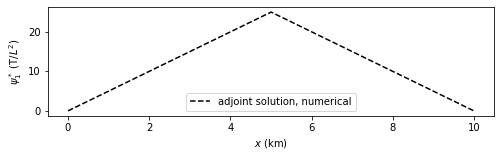

In [142]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([-1*np.ones([1,1]), np.ones([nrow, ncol-2], dtype=int), -1*np.ones([1,1])]), 
                         strt=np.zeros([nrow, ncol]))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=8);

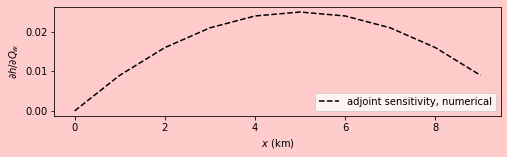

In [143]:
dhdQw = np.empty(0)
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, oc*1000, 1.]})
    M1.write_input()
    success, buff = M1.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
    dhdQw = np.append(dhdQw, A[oc])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdQw, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial Q_w$')
plt.legend()
f.patch.set_facecolor((1.0, 0.0, 0.0, 0.2))
s.set_facecolor((1.0, 0.0, 0.0, 0.01));

In [144]:
set_background('rgba(200, 0, 0, 0.2)')
print('%.6f'% dhdQw[int(np.where(X[::1000]==float(ocol))[0])])

0.024997
